# Time Series Comparison Models (SARIMAX Vs LSTM Vs fbprophet)

## Main Objective

The aims of this report is to compare different time series algorithms (SAIMAX, fbprophet and LSTM ), As part of this study; These models will be used alongside with time series for forecasting purpose  to assess the pros and cons for each one of them
Note: This study has been by run by using Modest workstation (specs):  
**Intel(R) Core ™ - 5i 6400 CPU @ 2.7GHz  
RAM (8GB).**


## Benefits:

In general, all Data scientists can benefit from this report however beginner Data scientist who just started their learning journey can benefit more as this study provides enough adequate details on creating time series models from scratch and by using real dataset. In addition to that, normal users who do not have machine learning workstation equipped by powerful tools like GPU can also benefit from this report.

## Dataset

Source:
You can download the dataset from Kaggle website (https://www.kaggle.com/c/m5-forecasting-accuracy/data), the source of this data is https://mofc.unic.ac.cy/m5-competition/
Dataset has been lunched as part of The M5 Competition
About Dataset:
It used hierarchical sales data, generously made available by Walmart, starting at the item level and aggregating to that of departments, product categories and stores in three geographical areas of the US: California, Texas, and Wisconsin.

Besides the time series data, it also included explanatory variables such as price, promotions, day of the week, and special events (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter) that affect sales which are used to improve forecasting accuracy.


## Data Attribute:

Dataset contains  4 CSV sheets as shown beknow:
* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
* sell_prices.csv - Contains information about the price of the products sold per store and date.
* sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

Each training dataset has around 30490 rows and 1919 columns, each row represents product, and each column represents day (time series is daily frequency)  

Listing all columns is not right option because their number is so high, however and for sake of this report we will shed light on the following columns:
d_number of days columns which represent days number starting from d_1,d_2,d_3 …d_1913, there are 1913 days which equal to  5 years (End of 2011 to mid of 2016) and two months, type of column is ‘integer
  
In addition to train dataset, Calendar dataset will be used to convert days number to datetime type and to create holidays dataset for fbprophet model 


## Import Libraries 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import seaborn as sns
import pmdarima as pm
from dateutil.relativedelta import relativedelta
import warnings
warnings.simplefilter(action='ignore')
from sklearn.metrics import accuracy_score
import time
#import tensorflow as tf
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#import fbprophet  if you have an issue with fbprophet on python3.8 i would suggest you to use python3.7 instead
#from fbprophet import Prophet

## Data cleaning / feature engineering

In [4]:
# reading and inserting the csv sheet into DataFrame
df = pd.read_csv('time/sales_train_validation.csv')
df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [8]:
# No null cells!!
df.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [10]:
# reading and inserting the calendar csv sheet into Dataframe, this data will be used as lookup to get the right date for each day in df dataframe
calendar = pd.read_csv('time/calendar.csv')
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


**Creating new Dataframe and set the datetime as index**

In [4]:
df.drop(columns=['item_id', 'dept_id','cat_id','store_id','state_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = df.T  # seting the days as index for new dataframe(Data)
data.columns = df['id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calendar['date'][0:1913]
data.index = pd.to_datetime(data.index)
data.index.freq= 'd'
data.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
               '2016-04-19', '2016-04-20', '2016-04-21', '2016-04-22',
               '2016-04-23', '2016-04-24'],
              dtype='datetime64[ns]', name='date', length=1913, freq='D')

**Since the number of products is so high we will focus on product with highest number purchasments, so below code will let us know which is this product** 

In [6]:
max_value =data.max().to_frame()
max_prod = max(data.max())
max_value.loc[max_value[0] == max_prod]

,0
id,
FOODS_3_090_CA_3_validation,763.0


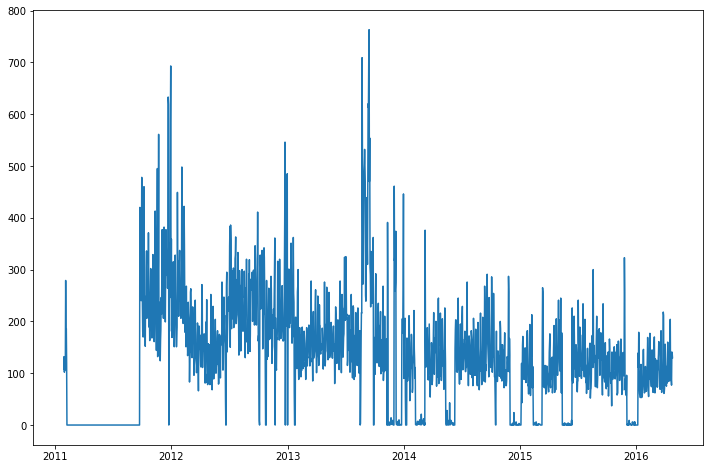

In [8]:
# WE noctice that numbe of purchasments is zero for arround first 10 months which looks justified if product was not linched or avaliable yet in the stores at that time, thats why this interval will be ecluded from time series 
plt.figure(figsize=(12,8))
plt.plot(data.index,data['FOODS_3_090_CA_3_validation'])

**Checking the type of time series (stationary or non-statinary)**

adf is -4.173018148719139
pvalue is 0.0007317275745300305


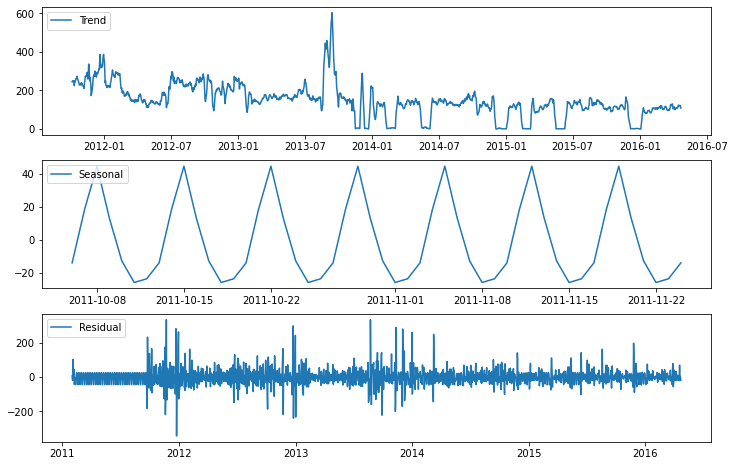

In [11]:
# Using the decompostion method...
ss_decomposition = seasonal_decompose(x=data['FOODS_3_090_CA_3_validation'])
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

#fig, ax = plt.subplots(3,1, figsize=(12,8))
fig, ax = plt.subplots(3,figsize=(12,8) )
#plt.figure(figsize=(12,5))
#plt.subplot(3,1,1)
ax[0].plot(data.index[250:],estimated_trend[250:], label='Trend')
ax[0].legend(loc='upper left')

#plt.subplot(3,1,2)
ax[1].plot(data.index[250:300],estimated_seasonal[250:300], label='Seasonal')
ax[1].legend(loc='upper left')

#plt.subplot(3,1,3)
ax[2].plot(data.index,estimated_residual, label='Residual')
ax[2].legend(loc='upper left')

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data['FOODS_3_090_CA_3_validation'])

print(f'adf is {adf}')
print(f'pvalue is {pvalue}')


We can see the p-value is **0.0007317275745300305** which is much less than .05 so we can reject the "null hypothesis" which says time series is not stationary  
let us plot the acf and pacf as well

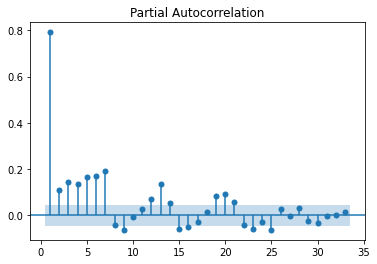

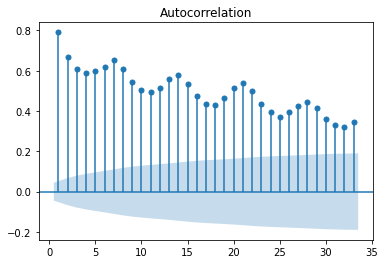

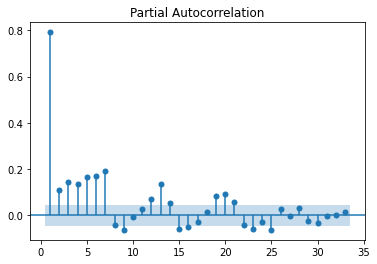

In [10]:
#plt.subplot(3,1,4)
plot_acf(data['FOODS_3_090_CA_3_validation'], zero=False)


#plt.subplot(3,1,5)
plot_pacf(data['FOODS_3_090_CA_3_validation'], zero=False)

**It cleary shows that data variance is not constant, let ys looking for some smoothing tool like differencing and log transformation**

adf is -9.690404728774508
pvalue is 1.1405330819669683e-16


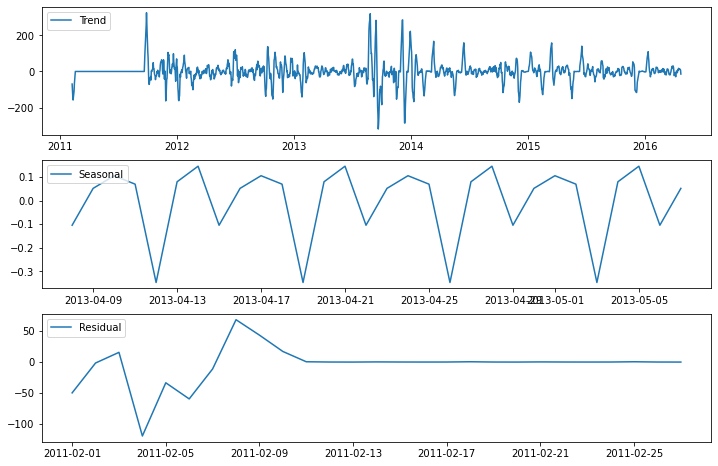

In [12]:
# diffrencing method

data['shift'] = data['FOODS_3_090_CA_3_validation'].shift(7)
data['week_lag'] = data['FOODS_3_090_CA_3_validation'] - data['shift']

ss_decomposition = seasonal_decompose(x=data['week_lag'].dropna())
lag_trend = ss_decomposition.trend
lag_seasonal = ss_decomposition.seasonal
lag_residual = ss_decomposition.resid

#fig, ax = plt.subplots(3,1, figsize=(12,8))
fig, ax = plt.subplots(3,figsize=(12,8) )
#plt.figure(figsize=(12,5))
#plt.subplot(3,1,1)
ax[0].plot(data.index[7:],lag_trend, label='Trend')
ax[0].legend(loc='upper left')

#plt.subplot(3,1,2)
ax[1].plot(data.index[800:830],lag_seasonal[800:830], label='Seasonal')
ax[1].legend(loc='upper left')

#plt.subplot(3,1,3)
ax[2].plot(data.index[:30],lag_residual[:30], label='Residual')
ax[2].legend(loc='upper left')

adf_dif, pvalue_dif,usedlag, nobs, critical_values, icbest = adfuller(data['week_lag'].dropna())

print(f'adf is {adf_dif}')
print(f'pvalue is {pvalue_dif}')


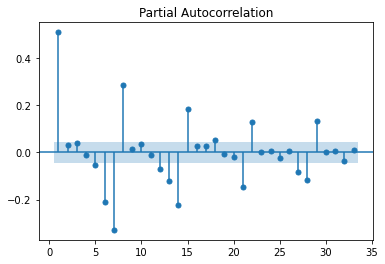

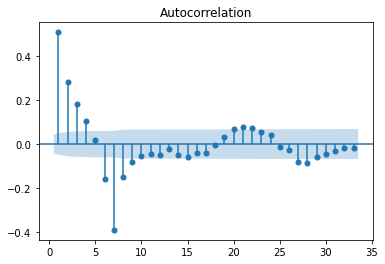

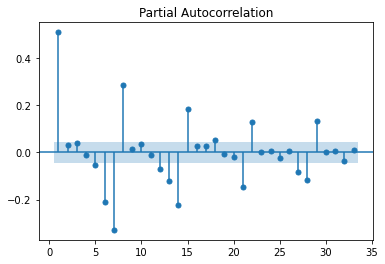

In [13]:
#plt.subplot(3,1,4)
plot_acf(data['week_lag'][7:],zero=False)


#plt.subplot(3,1,5)
plot_pacf(data['week_lag'][7:],zero=False)

**WE see that differencing has reducing somehow the range of variance  
let us try now the log transformation** 

adf is -4.548016527749815
pvalue is 0.0001608750636803138


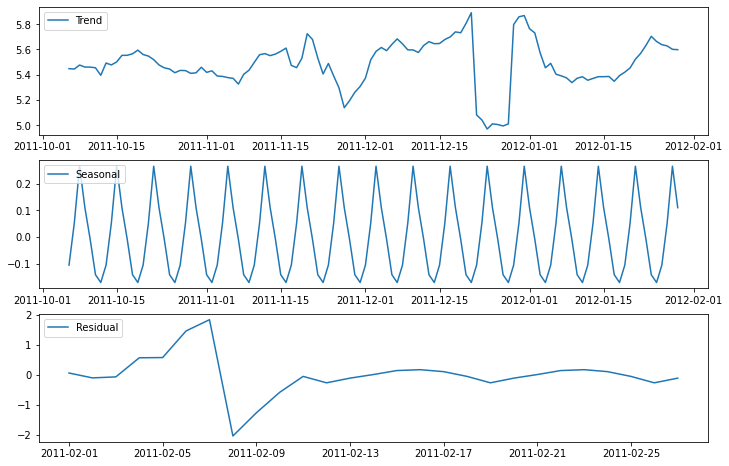

In [14]:
# Log Transformation method

log_transformed = np.log1p(data['FOODS_3_090_CA_3_validation'].astype('float'))

ss_decomposition = seasonal_decompose(x=log_transformed)
log_trend = ss_decomposition.trend
log_seasonal = ss_decomposition.seasonal
log_residual = ss_decomposition.resid

#fig, ax = plt.subplots(3,1, figsize=(12,8))
fig, ax = plt.subplots(3,figsize=(12,8) )
#plt.figure(figsize=(12,5))
#plt.subplot(3,1,1)
ax[0].plot(data.index[250:366],log_trend[250:366], label='Trend')
ax[0].legend(loc='upper left')

#plt.subplot(3,1,2)
ax[1].plot(data.index[250:366],log_seasonal[250:366], label='Seasonal')
ax[1].legend(loc='upper left')

#plt.subplot(3,1,3)
ax[2].plot(data.index[:30],log_residual[:30], label='Residual')
ax[2].legend(loc='upper left')

adf_log, pvalue_log, usedlag, nobs, critical_values, icbest = adfuller(log_transformed)

print(f'adf is {adf_log}')
print(f'pvalue is {pvalue_log}')


**Its also reduce the variance**

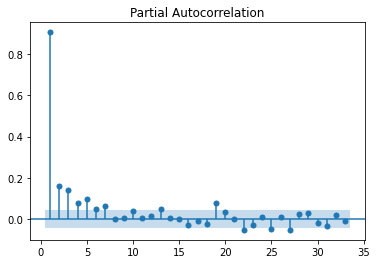

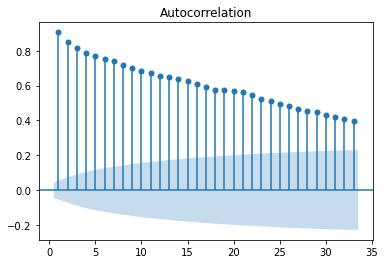

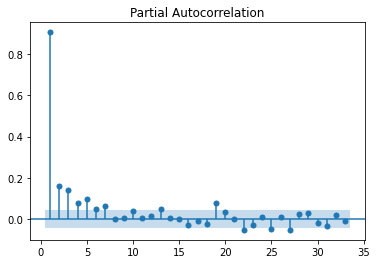

In [15]:
#plt.subplot(3,1,4)
plot_acf(log_transformed,zero=False)


#plt.subplot(3,1,5)
plot_pacf(log_transformed,zero=False)

## SARIMA MODEL

**Preparing the training and testing data for all models**

In [5]:
start_interval = 250 # removing the intial interval where no sold item data is shown
test_sample= 100
train_SARIMA = data['FOODS_3_090_CA_3_validation'][start_interval:-test_sample].astype('float')
test_SARIMA = train_SARIMA[-test_sample:].astype('float')
train_LSTM = data['FOODS_3_090_CA_3_validation'][start_interval:-2*test_sample].astype('float')
test_LSTM = data['FOODS_3_090_CA_3_validation'][-2*test_sample:-test_sample].astype('float')
train_prophet = data[['FOODS_3_090_CA_3_validation']][start_interval:-test_sample].astype('float')
true = data['FOODS_3_090_CA_3_validation'][-test_sample:].astype('float')
print('full data length', data[['FOODS_3_090_CA_3_validation']][start_interval:].shape)
print('train_SARIMA', train_SARIMA.shape)
print('test_SARIMA', test_SARIMA.shape)
print('train_LSTM', train_LSTM.shape)
print('test_LSTM', test_LSTM.shape)
print("train prophet", train_prophet.shape)
print("true ", true.shape)

full data length (1663, 1)
train_SARIMA (1563,)
test_SARIMA (100,)
train_LSTM (1463,)
test_LSTM (100,)
train prophet (1563, 1)
true  (100,)


**Tuning the hyparameter by using auto arima method**

In [ ]:
# reduce the data size to emhance the performance
stepwise_model = pm.auto_arima(train[400:], start_p=0, start_q=0,
                           max_p=6, max_q=3, m=42,
                           start_P=0, seasonal=True,start_Q=0,
                           d=1, D=0,max_P=6,max_Q=3,max_d=3,max_D=3, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,trend='n')
print(stepwise_model.aic())
print(stepwise_model.bic())

**Tuning the hyparameter by using self developed method aims to reduce the number of iteration in order to engance the performance of this workstation**

In [ ]:
# Custamized grid search function
from numpy import median
import math
import statistics
p_min = 0
p_max = 6
d_min=0
d_max=3
q_min = 0
q_max=3
P_min = 0
P_max = 6
D_min=0
D_max=3
Q_min = 0
Q_max=3
trend= 'n' # ['n','c','t','ct']
m=42

p_m = int(round(median([p_min,p_max]),0))
d_m = int(round(median([d_min,d_max]),0))
q_m = int(round(median([q_min,q_max]),0))
P_m = int(round(median([P_min,P_max]),0))
D_m = int(round(median([D_min,D_max]),0))          
Q_m = int(round(median([Q_min,Q_max]),0))          
          

start_time = time.time()


result = []

if (p_m,d_m,q_m) != (p_max,d_max,q_max):
    seasonal_order = (P_m,D_m,Q_m,m)
    model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=(p_m,q_m,d_m), seasonal_order=seasonal_order, trend='n').fit()
    yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
    rmse_m = sum(abs(yhat - true))
    result.append(({'order': (p_m,d_m,q_m),'seasonal_order': seasonal_order,'rmse':rmse_m}))
    print(order,seasonal_order,'rmse_(p_m,q_m,d_m):', rmse_m)

    model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=(p_max,d_max,q_max), seasonal_order=seasonal_order, trend='n').fit()
    yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
    rmse_max = sum(abs(yhat - true))
    result.append(({'order': (p_max,d_maz,q_max),'seasonal_order': seasonal_order,'rmse':rmse_max}))
    print(order,seasonal_order,'rmse_(p_max,d_max,q_max):',rmse_max)

    model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=(p_min,d_min,q_min), seasonal_order=seasonal_order, trend='n').fit()
    yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
    rmse_min = sum(abs(yhat - true))
    result.append(({'order': (p_min,q_min,d_min),'seasonal_order': seasonal_order,'rmse':rmse_min}))
    print(order,seasonal_order,'rmse_(p_min,d_min,q_min):',rmse_min)
    
   
    if rmse_max < rmse_min:
        p_loop = range(p_m + 1,p_max)
        d_loop = range(d_m + 1,d_max)
        q_loop = range(q_m + 1,q_max)
    else:
        p_loop = range(p_min + 1,p_m)
        d_loop = range(d_min + 1,d_m)
        q_loop = range(q_min + 1,q_m)
        
        
    for p_ in p_loop:
        for d_ in d_loop:
            for q_ in q_loop:
                start_time = time.time()
                order=(p_,d_,q_)
                seasonal_order = (P,D,Q,m)
                model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
                yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
                rmse = sum(abs(yhat - true))
                result.append(({'order':order,'seasonal_order':seasonal_order,'rmse':rmse}))
                duration = time.time() - start_time
                print(order,seasonal_order,'rmse:' ,rmse , 'duration:',duration)
    output = pd.DataFrame(result)
    fit_model = output[output['rmse'] == (output['rmse'].min())]
    order_fit = fit_model.order.values[0]
    
    
    if (P_m,D_m,Q_m) != (P_max,D_max,Q_max):
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order_fit, seasonal_order=(P_m,D_m,Q_m,m), trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        Rmse_m = sum(abs(yhat - true))
        result.append(({'order': order_fit,'seasonal_order': (P_m,D_m,Q_m,m),'rmse':Rmse_m}))
        print(order_fit,seasonal_order,'Rmse_(P_m,D_m,Q_m,m):', Rmse_m)
            
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order_fit, seasonal_order=(P_max,D_max,Q_max,m), trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        Rmse_max = sum(abs(yhat - true))
        result.append(({'order': order_fit,'seasonal_order': (P_max,D_max,Q_max,m),'rmse':Rmse_max}))
        print(order_fit,seasonal_order,'Rmse_(P_max,D_max,Q_max,m):',Rmse_max)
        
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order_fit, seasonal_order=(P_min,D_min,Q_min,m), trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        Rmse_min = sum(abs(yhat - true))
        result.append(({'order': order_fit,'seasonal_order': (P_min,D_min,Q_min,m),'rmse':Rmse_min}))
        print(order_fit,seasonal_order,'Rmse_(P_min,D_min,Q_min,m):',Rmse_min)

        
        if rmse_max < rmse_min:
            P_loop = range(P_m + 1,P_max)
            D_loop = range(D_m + 1,D_max)
            Q_loop = range(Q_m + 1,Q_max)
        else:
            P_loop = range(P_min + 1,P_m)
            D_loop = range(D_min + 1,D_m)
            Q_loop = range(Q_min + 1,Q_m)
        
        
        for P_ in P_loop:
            for D_ in D_loop:
                for Q_ in Q_loop:
                    start_time = time.time()
                    model2 = sm.tsa.statespace.SARIMAX(train_SARMIA[-400:], order=order_fit, seasonal_order=(P_,D_,Q_,m), trend='n').fit()
                    yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
                    rmse = sum(abs(yhat - true))
                    result.append(({'order':order_fit,'seasonal_order':(P_,D_,Q_,m),'rmse':rmse}))
                    duration = time.time() - start_time
                    print(order_fit,(P_,D_,Q_,m),'rmse:' ,rmse , 'duration:',duration)
        output2 = pd.DataFrame(result)
        fit_model2 = output2[output2['rmse'] == (output2['rmse'].min())]
        print('best model: ',fit_model2.order.values,fit_model2.seasonal_order.values, 'rmse:', fit_model2.rmse.values)
    
    
    else:
        order = order_fit
        seasonal_order_best = (P_m,D_m,Q_m,m)
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        rmse = sum(abs(yhat - true))
        result.append(({'order': order,'seasonal_order': seasonal_order,'rmse':rmse}))
        print(order,seasonal_order,'rmse:',rmse)

else:
    order_fit = (p_m,q_m,d_m)
    if (P_m,D_m,Q_m) != (P_max,D_max,Q_max):
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order_fit, seasonal_order=(P_m,D_m,Q_m,m), trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        Rmse_m = sum(abs(yhat - true))
        result.append(({'order': order_fit,'seasonal_order': (P_m,D_m,Q_m,m),'rmse':Rmse_m}))
        print(order_fit,seasonal_order,'Rmse_(P_m,D_m,Q_m,m):', Rmse_m)
            
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order_fit, seasonal_order=(P_max,D_max,Q_max,m), trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        Rmse_max = sum(abs(yhat - true))
        result.append(({'order': order_fit,'seasonal_order': (P_max,D_max,Q_max,m),'rmse':Rmse_max}))
        print(order_fit,seasonal_order,'Rmse_(P_max,D_max,Q_max,m):',Rmse_max)
            
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order_fit, seasonal_order=(P_min,D_min,Q_min,m), trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        Rmse_min = sum(abs(yhat - true))
        result.append(({'order': order_fit,'seasonal_order': (P_min,D_min,Q_min,m),'rmse':Rmse_min}))
        print(order_fit,seasonal_order,'Rmse_(P_min,D_min,Q_min,m):',Rmse_min)
        
        
            
        if rmse_max < rmse_min:
            P_loop = range(P_m + 1,P_max)
            D_loop = range(D_m + 1,D_max)
            Q_loop = range(Q_m + 1,Q_max)
            
        else:
            P_loop = range(P_min + 1,P_m)
            D_loop = range(D_min + 1,D_m)
            Q_loop = range(Q_min + 1,Q_m)
            
        
        for P_ in P_loop:
            for D_ in D_loop:
                for Q_ in Q_loop:
                    start_time = time.time()
                    model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order_fit, seasonal_order=(P_,D_,Q_,m), trend='n').fit()
                    yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
                    rmse = sum(abs(yhat - true))
                    result.append(({'order':order_fit,'seasonal_order':(P_,D_,Q_,m),'rmse':rmse}))
                    duration = time.time() - start_time
                    print(order_fit,(P_,D_,Q_,m),'rmse:' ,rmse , 'duration:',duration)
        
        
        output2 = pd.DataFrame(result)
        fit_model2 = output2[output2['rmse'] == (output2['rmse'].min())]
        print('best model: ',fit_model2.order.values,fit_model2.seasonal_order.values, 'rmse:', fit_model2.rmse.values)
        
    else:
        seasonal_order_best = (P_m,D_m,Q_m,m)
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order_fit, seasonal_order=seasonal_order, trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        rmse = sum(abs(yhat - true))
        result.append(({'order': order,'seasonal_order': seasonal_order,'rmse':rmse}))
        print(order,seasonal_order,'rmse:',rmse)
 
duration= time.time() - start_time
print(duration)

**Building and fitting SARIMX model**

In [10]:
# Auto arima model (Best Model)
start_time = time.time()
seasonal_order = (6, 0, 1, 42)
order_m = (3,1,1)
model_sarima = sm.tsa.statespace.SARIMAX(train_SARIMA, order=order_m, seasonal_order=seasonal_order, trend='n').fit()
duration = (time.time() - start_time) / 60
print(f'training is done within:{duration} minutes')

training is done within:42.423664100964864 minutes


In [11]:
# out of sample prediction:
yhat_sarima = model_sarima.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True)

**Calculating the residual for SARIMX model**

In [14]:
SARIMA_residual = sum(abs(yhat_sarima - true))
SARIMA_residual

5137.127066819323

In [46]:
future_fcst = model_sarima.get_forecast(100)
# That will have a method to pull in confidence interval 
confidence_int = future_fcst.conf_int(alpha = 0.01)
confidence_int['yhat'] = abs(confidence_int['lower FOODS_3_090_CA_3_validation'] + confidence_int['upper FOODS_3_090_CA_3_validation']/2)
confidence_int

,lower FOODS_3_090_CA_3_validation,upper FOODS_3_090_CA_3_validation,yhat
2016-01-16,-74.528669,259.835657,55.389160
2016-01-17,-127.679099,252.879289,1.239454
2016-01-18,-144.204741,252.768000,17.820741
2016-01-19,-150.872437,258.956585,21.394145
2016-01-20,-162.220129,257.404868,33.517695
...,...,...,...
2016-04-20,-406.805794,466.944719,173.333435
2016-04-21,-403.602937,474.735098,166.235387
2016-04-22,-374.715571,508.185165,120.622989
2016-04-23,-367.193413,520.246011,107.070408


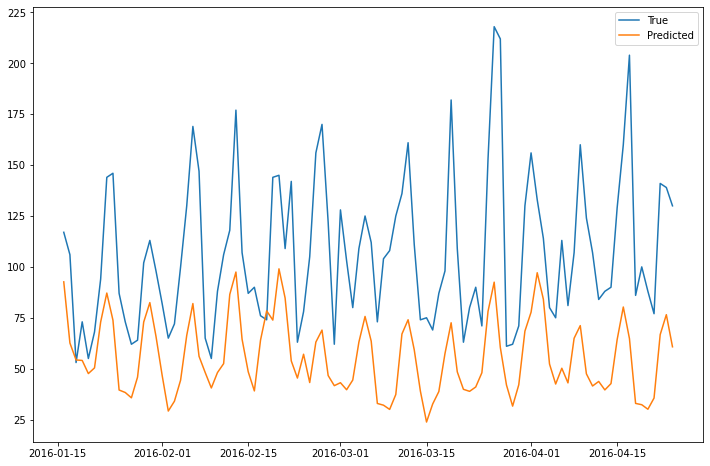

In [63]:
plt.figure(figsize=(12,8))
plt.plot(true, label='True')
plt.plot(yhat_sarima, label='Predicted')
#plt.plot(confidence_int['yhat'], label='Upper-Predicted')
plt.legend()

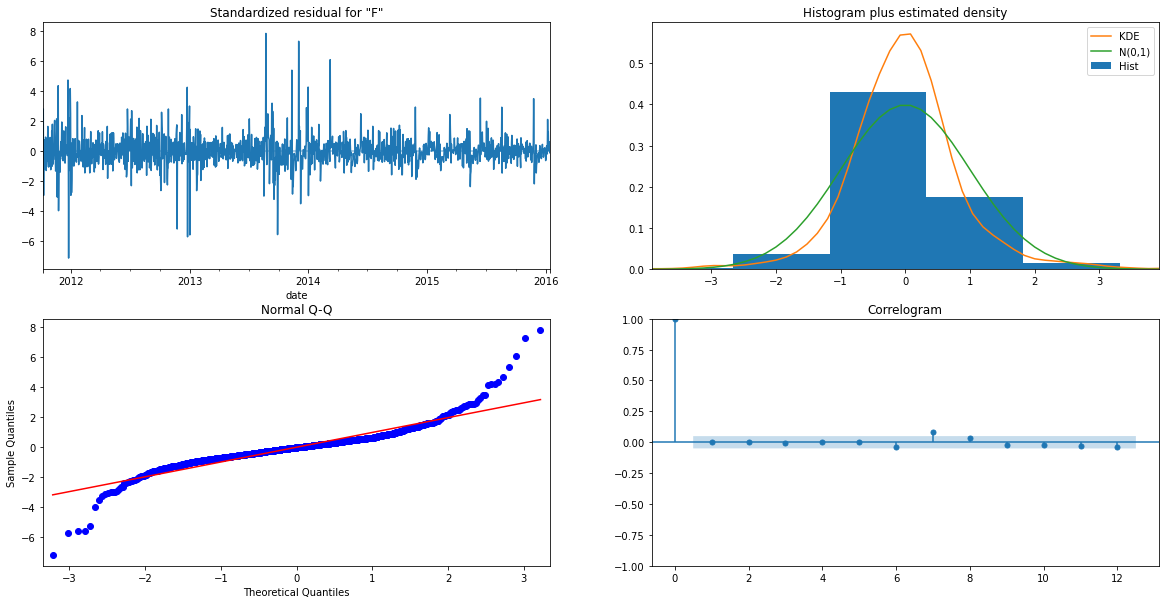

In [21]:
model_sarima.plot_diagnostics(lags=12,figsize = (20,10),);

## LSMT Model

In [15]:
# Create x_train,y_train for LSTM model

input_days = 12
x_train, y_train = [],[]
for i in range(0,train_LSTM.shape[0] - input_days,3):
    x_train.append(train_LSTM[i:i+input_days])
    y_train.append(train_LSTM[i+input_days])

    
x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
y_train = np.asarray(y_train)
print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)

x_train shape (484, 12, 1)
y_train shape (484,)


In [ ]:
# building simple LSMT model:

start_time = time.time()
cell_units = 500
epochs = 3000

model_LSTM = Sequential() 

model_LSTM.add(LSTM(cell_units,input_shape=(x_train.shape[1],1))) #return_sequences= True))
    

model_LSTM.add(Dense(1))
    

model_LSTM.compile(loss='mean_squared_error', optimizer='adam')
model_LSTM.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1)


duration = (time.time() - start_time) / 60
print(f'training is done within:{duration} minutes')

Training of LSTM is done within:62.36192864179611 minutes

In [17]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500)               1004000   
_________________________________________________________________
dense (Dense)                (None, 1)                 501       
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


**Prediction of LSTM model**

In [18]:
# Creating x_test data (its shape should be match with training data and with input_shape)
x_test = []
for i in range(0,test_LSTM.shape[0] - input_days + 1):
    x_test.append(test_LSTM[i:i + input_days])
               
x_test = np.asarray(x_test)    
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print('x_test shape', x_test.shape)


x_test shape (89, 12, 1)


In [19]:
# prediction function which goes through each row, and each contains 12 data cells and eacj cell value will be replaced by 
# predicted value...
pred = []

for i in range(x_test.shape[0]):
    for _ in range(x_test.shape[1]):
        prediction = model_LSTM.predict(x_test[i:i+1,:,:])
        pred.append(prediction)
        x_test[i,:-1,:] = x_test[i,1:,:]
        x_test[i,-1,:] = prediction

In [21]:
# Reshape the output of precidiction array from (89,12,1) shape to (100,) shape
yhat_lstm = np.arange(0,100,1,'float')
y_flatten = x_test.flatten()
yhat_lstm[:12] = y_flatten[:12]
k = 2
for i in range(12,test_LSTM.shape[0]):
    yhat_lstm[i] = y_flatten[(k*12) - 1]
    k +=1
    
lstm_result = pd.DataFrame(data=yhat_lstm, index=true.index, columns=['yhat'])
lstm_result['true'] = true

**Residual for LSTM**

In [22]:
lstm_residual = sum(abs(lstm_result['yhat'] - true))
lstm_residual

6837.086668014526

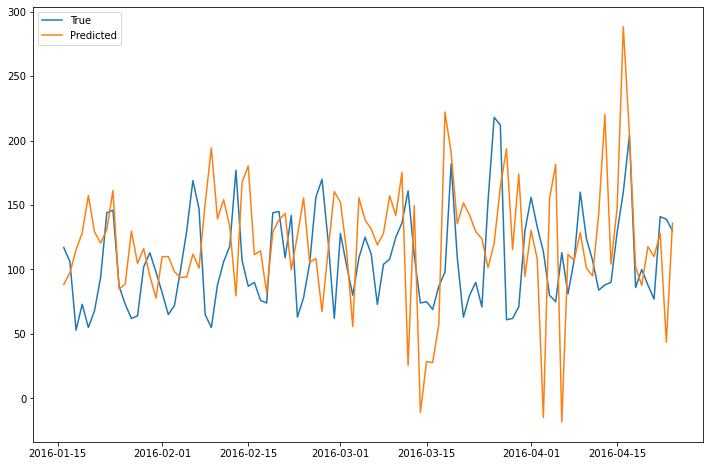

In [90]:
plt.figure(figsize=(12,8))
plt.plot(true, label='True')
plt.plot(lstm_result.yhat, label='Predicted')
plt.legend()

## fbprophet Model

In [6]:
# prepare dataframe for fprophet model
train_prophet['ds'] = train_prophet.index.values
train_prophet.rename(columns={'FOODS_3_090_CA_3_validation':'y'},inplace=True)
train_prophet = train_prophet[['ds','y']]
train_prophet.columns.name = None
train_prophet

,ds,y
date,,
2011-10-06,2011-10-06,249.0
2011-10-07,2011-10-07,254.0
2011-10-08,2011-10-08,460.0
2011-10-09,2011-10-09,170.0
2011-10-10,2011-10-10,229.0
...,...,...
2016-01-11,2016-01-11,68.0
2016-01-12,2016-01-12,59.0
2016-01-13,2016-01-13,94.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training is done within:2.783449649810791 minutes


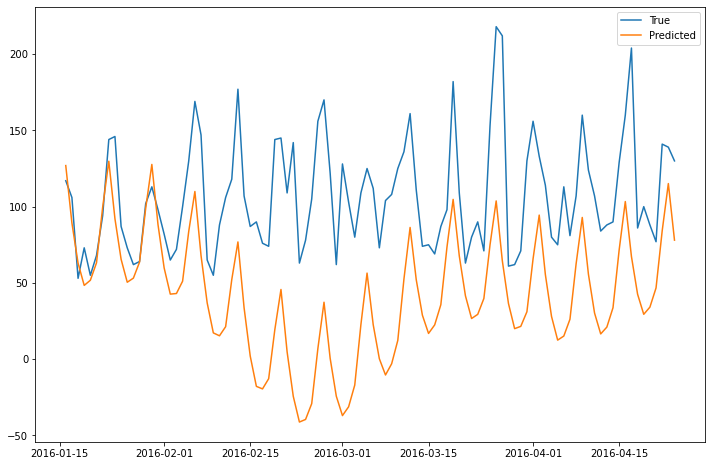

In [9]:
#fprophet model without holidays
start_time = time.time()
m = Prophet(weekly_seasonality=True)
m.fit(train_prophet)

future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)
predicted_prophet = forecast[['yhat']][-test_sample:]
predicted_prophet.set_index(true.index,inplace=True)
predicted_prophet.index

duration = time.time() - start_time
print(f'training is done within:{duration} minutes')


plt.figure(figsize=(12,8))
plt.plot(true, label='True')
plt.plot(predicted_prophet, label='Predicted')
plt.legend()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


training is done within:2.783449649810791 minutes


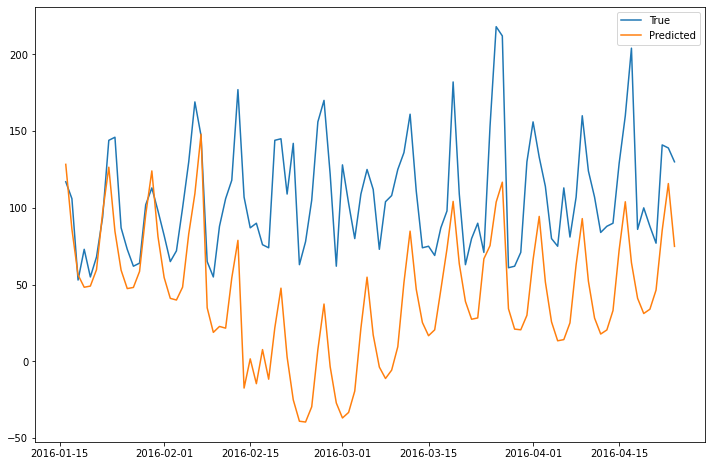

In [10]:
#fprophet model with holidays

holidays = calendar[calendar['event_type_1'].isnull() == False]
holidays = holidays[['date','event_name_1', 'event_type_1']]
holidays.rename(columns={'date':'ds','event_name_1':'holiday'},inplace=True)

start_time = time.time()

m_holi = Prophet(weekly_seasonality=True,holidays=holidays)
m_holi.fit(train_prophet)

future = m_holi.make_future_dataframe(periods=100)
forecast = m_holi.predict(future)
predicted_prophet = forecast[['yhat']][-test_sample:]
predicted_prophet.set_index(true.index,inplace=True)
predicted_prophet.index

print(f'training is done within:{duration} minutes')

plt.figure(figsize=(12,8))
plt.plot(true, label='True')
plt.plot(predicted_prophet, label='Predicted')
plt.legend()

**fbprophet Residual**

In [17]:
prophet_residuals = sum(abs(predicted_prophet.yhat.values - true))
prophet_residuals

6479.796768344162

## Recomended Model

| Model | Trsining Time (minutes) | Residual* |
| --- | --- | --- |
| SARIMAX | 43 | 5137 |
| pbprophet | 2.78 | 6480 |
| LSTM | 43 | 6837 |
Riesdual = sum(abs(true - yhat))

I do not think its easy task to select one model over other! considering that results are close to each other and do not best fit the Actual values as per the expectation, so I would answer this question by saying:
* SARIMAX model residual is the lowest one and the shape of the predicted values is best match the shape of actual values then SARIMAX model will be the recommended model consedering its more open for enhancement via tune hyperparameter, the only limitation comes from hardware requirments since powerful workstation is high requiered to perform grid searching which go through high number of iterations. 

* Fbprophet will be good option if short term forecasting is required (let us say for two weeks period), its training time is the lowest and does not need powerful workstation, so its good choice especially if number of time series which need to be forecasted is high, there is no big room for enhancments becuase via hyperparameter as its in SARIMAX model but its performance and ability to fitech the seasonality give its good credit.

* LSTM model could be also selected if dataset is big enough so it can get the pattern properly and if powerful workstation equipped with  GPU and high RAM is available.



## Key Findings and Insights

* Grid search methods is high important to tune the parameter for SARIMAX and auto arima tool is good choice, however running such tool requires powerful workstation!
* SARIMAX model has a lot of parameter which considers as a challenge for beginner data scientist,thus running grid search tool is crucial in such case.
* Fbprophet  is easy to use, quick to train and does not need high tuning however it has limited range of enhancements, its good fit for forcasting short term pariods.
* LSTM requires big volume dataset and is black box and  requires more effort and little bit experienced pythove skills espically when preparing its training and testing  array dataset.
* Powerful workstation will make your life  easy and safe your time.


## Next Steps

* Revisiting this study once hardware requirements are in the place
* Explore new model for time series and looking for combination of different models when time series specifications are variant.
* Working on tuning parameter of these models could lead to more accurate models.
* Getting dataset with more number of entries and variety will be good suggestion to test these models and figure out their pros and cons.
* participating in forecasting all products avaliable in the dataset and would recomend multivariate tools.
